#  Batch39_20180421_ANNLab_ClassificationActivity_BackOrders

---------------------------------------------------------------------------------------

### Problem Statement

    Identify products at risk of backorder before the event occurs so the business has time to react. 

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

### Data Pre-processing
#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline  
import os

Using TensorFlow backend.


#### Loading the data

In [2]:
os.getcwd()

'F:\\Batch39\\CSE7321c\\Lab\\20180421_Batch39_CSE7321c_Lab01_ANN_Classification'

In [3]:
#For setting working directory, if required
#os.chdir('path to file)

In [2]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the number row and columns

In [3]:
data.shape

(61589, 23)

Display the columns

In [4]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [5]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [6]:
data[:3]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe.

For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. 

The top is the most common value.

The freq is the most common value’s frequency.

Timestamps also include the first and last items.

In [7]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [9]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

sku is Categorical but is interpreted as int64 
potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also 
categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [8]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [9]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

##### Delete sku attribute

In [10]:
np.size(np.unique(data.sku))

61589

In [11]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

Missing value analysis and dropping the records with missing values

In [12]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [13]:
print (data.shape)

(61589, 22)


In [14]:
#Since the number of missing values is about 5%. For initial analysis we ignore all these records
data = data.dropna(axis=0)

In [15]:
print(data.isnull().sum())
print("----------------------------------")
print(data.shape)

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64
----------------------------------
(58186, 22)


#### Converting Categorical to Numeric

For some of the models all the independent attribute should be of type numeric and ANN model is one among them.
But this data set has some categorial attributes.

'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [16]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


##### Creating dummy variables.

If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [17]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [18]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, prefix=categorical_Attributes, prefix_sep="_",drop_first=True)

In [19]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Target attribute distribution

In [20]:
pd.value_counts(data['went_on_backorder_Yes'])

0    47217
1    10969
Name: went_on_backorder_Yes, dtype: int64

#### Train-Test Split

Using sklearn.model_selection.train_test_split

    Split arrays or matrices into train and test subsets

In [21]:
#Performing train test split on the data
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = data['went_on_backorder_Yes'])


In [22]:
#To get the distribution in the target in train and test
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33052
1     7678
dtype: int64
0    14165
1     3291
dtype: int64


-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------

### Logistic Regression Modelling

##### Building a logistic regression model using sklearn

In [23]:
classifier = LogisticRegression(random_state=123)

In [24]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Predictions

In [25]:
# Predictions on train data
train_pred = classifier.predict(X_train)
# Predictions on test data
test_pred = classifier.predict(X_test)

##### Confusion Matrix

In [26]:
# Train data
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print("Confusion Matrix - Train Data: \n", confusion_matrix_train)
# Test data
confusion_matrix_test= confusion_matrix(y_test, test_pred)
print("Confusion Matrix - Test Data: \n", confusion_matrix_test)

Confusion Matrix - Train Data: 
 [[32916   136]
 [ 6912   766]]
Confusion Matrix - Test Data: 
 [[14109    56]
 [ 2962   329]]


##### Error Metrics

In [27]:
# Metrics on train data for logistic regression model
#Accuracy
accuracy_Train_logReg = (confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#specificity or true negative rate (TNR)
specificity_Train_logReg = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Train_logReg = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#precision
precision_Train_logReg = confusion_matrix_train[1,1]/(confusion_matrix_train[0,1]+confusion_matrix_train[1,1])

print("Train Specificity: ",specificity_Train_logReg)
print("Train Recall: ",recall_Train_logReg)
print("Train Precision: ",precision_Train_logReg)
print("Train Accuracy: ",accuracy_Train_logReg)

Train Specificity:  0.995885271693
Train Recall:  0.0997655639489
Train Precision:  0.849223946785
Train Accuracy:  0.826958016204


In [28]:
# Metrics on test data
#Accuracy
accuracy_Test_logReg = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#specificity or true negative rate (TNR)
specificity_Test_logReg = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Test_logReg = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#precision
precision_Test_logReg = confusion_matrix_test[1,1]/(confusion_matrix_test[0,1]+confusion_matrix_test[1,1])

print("Test Specificity: ",specificity_Test_logReg)
print("Test Recall: ",recall_Test_logReg)
print("Test Precision: ",precision_Test_logReg)
print("Test Accuracy: ",accuracy_Test_logReg)

Test Specificity:  0.996046593717
Test Recall:  0.0999696140991
Test Precision:  0.854545454545
Test Accuracy:  0.827108157654


-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------

## Introduction to Keras

![](img/fc_dense_layers_keras.jpg)

##### A. The core data structure of Keras is a model, a way to organize layers. The simplest type of model is the Sequential model, a linear stack of layers. 

* The keras sequential api enables us to build common yet complex neural network architectures flexibly

* Objects of the Keras sequential class, can have multiple neural network layers stacked on top of one another

![](img/keras_sequential_api.jpg)

In [32]:
from keras.models import Sequential

model = Sequential()

In [34]:
from keras.layers import Dense

model.add(Dense(units=64, input_dim=100, activation='relu', ))
model.add(Dense(units=10, activation='softmax'))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 7,114
Trainable params: 7,114
Non-trainable params: 0
_________________________________________________________________


##### B. Compilation
Before training a model, you need to configure the learning process, which is done via the compile method. receives three arguments

* optimizer - An optimizer. An optimizer is an algorithm that uses this feedback signal, to actually update the weights so that the output from the network gets closer to the ground truth.
* loss - A loss function. This is the objective that the model will try to minimize.
* metrics - A list of error metrics. This is for users reference and does not add value to the weights calculations.

In [36]:
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

##### C. Training
Keras models are trained on Numpy arrays of input data and labels. For training a model, you will typically use the  fit function

* epoch = one forward pass and one backward pass of all the training examples
* batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.


In [ ]:
# NOTE : Don't run the following line of code as we do not yet have X_train and y_train

model.fit(X_train, y_train, epochs=100, batch_size=64)

## ANN Model Building

#### A. Base model


In [29]:
perceptron_model = Sequential()

perceptron_model.add(Dense(1, input_dim=21, activation='sigmoid', kernel_initializer='normal'))

In [30]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
perceptron_model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
40730/40730 [==============================] - 2s 55us/step - loss: 0.4925 - acc: 0.8387: 1s - loss: 0.5659 - a
Epoch 2/30
40730/40730 [==============================] - 1s 21us/step - loss: 0.4047 - acc: 0.8509
Epoch 3/30
40730/40730 [==============================] - 1s 21us/step - loss: 0.4035 - acc: 0.8543
Epoch 4/30
40730/40730 [==============================] - 1s 20us/step - loss: 0.4158 - acc: 0.8576
Epoch 5/30
40730/40730 [==============================] - 1s 22us/step - loss: 0.4564 - acc: 0.8557: 0s - loss: 0.3947 - 
Epoch 6/30
40730/40730 [==============================] - 1s 22us/step - loss: 0.4113 - acc: 0.8601
Epoch 7/30
40730/40730 [==============================] - 1s 21us/step - loss: 0.4109 - acc: 0.8628
Epoch 8/30
40730/40730 [==============================] - 1s 21us/step - loss: 0.4036 - acc: 0.8635
Epoch 9/30
40730/40730 [==============================] - 1s 21us/step - loss: 0.4209 - acc: 0.8634
Epoch 10/30
40730/40730 [==============================

##### Predictions

In [32]:
test_pred=perceptron_model.predict_classes(X_test)
train_pred=perceptron_model.predict_classes(X_train)

confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)



[[32322   730]
 [ 5121  2557]]
[[13833   332]
 [ 2178  1113]]


##### Train Test Accuracy, True Negative Rate and True Positive Rate

In [41]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)
print("-----------------------")

Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Train TNR:  0.966477066441
Train TPR:  0.456759572805
Train Accuracy:  0.870390375644
-----------------------
Test TNR:  0.964701729615
Test TPR:  0.449407474932
Test Accuracy:  0.867552703941


#### Adding a hidden layer

In [37]:
mlp_model = Sequential()

mlp_model.add(Dense(12, input_dim=21, activation='relu', kernel_initializer='normal'))
mlp_model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [38]:
mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
#model_history = ann_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)
model_history = mlp_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/30
32584/32584 [==============================] - 1s 37us/step - loss: 0.4125 - acc: 0.8215 - val_loss: 0.3303 - val_acc: 0.8526
Epoch 2/30
32584/32584 [==============================] - 1s 22us/step - loss: 0.3080 - acc: 0.8667 - val_loss: 0.3047 - val_acc: 0.8802
Epoch 3/30
32584/32584 [==============================] - 1s 22us/step - loss: 0.2924 - acc: 0.8878 - val_loss: 0.2923 - val_acc: 0.8936
Epoch 4/30
32584/32584 [==============================] - 1s 22us/step - loss: 0.2785 - acc: 0.8962 - val_loss: 0.2871 - val_acc: 0.8920
Epoch 5/30
32584/32584 [==============================] - 1s 22us/step - loss: 0.2737 - acc: 0.8965 - val_loss: 0.2810 - val_acc: 0.8968
Epoch 6/30
32584/32584 [==============================] - 1s 22us/step - loss: 0.2679 - acc: 0.8983 - val_loss: 0.3024 - val_acc: 0.8891
Epoch 7/30
32584/32584 [==============================] - 1s 30us/step - loss: 0.2689 - acc: 0.8980 - val_loss: 0.2706 - val_acc:

#### Predictions

In [45]:
train_pred = mlp_model.predict_classes(X_train)

test_pred = mlp_model.predict_classes(X_test)

13376/17456 [=====================>........] - ETA: 0s

#### Getting evaluation metrics and evaluating model performance

In [40]:
confusion_matrix_train = confusion_matrix(y_train, train_pred)
confusion_matrix_test = confusion_matrix(y_test, test_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32322   730]
 [ 5121  2557]]
[[13833   332]
 [ 2178  1113]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [41]:
# Metrics on train data for ann_model 1
#Accuracy
accuracy_Train_M1 = (confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#specificity or true negative rate (TNR)
specificity_Train_M1 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Train_M1 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#precision
precision_Train_M1 = confusion_matrix_train[1,1]/(confusion_matrix_train[0,1]+confusion_matrix_train[1,1])

print("Train Specificity: ",specificity_Train_M1)
print("Train Recall: ",recall_Train_M1)
print("Train Precision: ",precision_Train_M1)
print("Train Accuracy: ",accuracy_Train_M1)

Train Specificity:  0.977913590706
Train Recall:  0.333029434749
Train Precision:  0.777912990569
Train Accuracy:  0.856346673214


In [42]:
# Metrics on test data
#Accuracy
accuracy_Test_M1 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#specificity or true negative rate (TNR)
specificity_Test_M1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Test_M1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#precision
precision_Test_M1 = confusion_matrix_test[1,1]/(confusion_matrix_test[0,1]+confusion_matrix_test[1,1])

print("Test Specificity: ",specificity_Test_M1)
print("Test Recall: ",recall_Test_M1)
print("Test Precision: ",precision_Test_M1)
print("Test Accuracy: ",accuracy_Test_M1)

Test Specificity:  0.976561948465
Test Recall:  0.338195077484
Test Precision:  0.770242214533
Test Accuracy:  0.856209899175


##### Plot

In [49]:
print(model_history.history.keys())


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


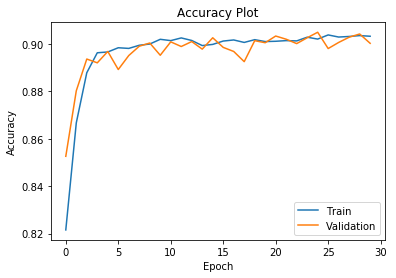

In [43]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

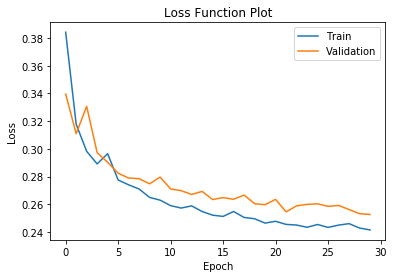

In [51]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### Experimenting with Hidden Layers

We have to be careful about overfitting!!!

In [52]:
ann_model_hiddenExp = Sequential()

# Adding more hidden layers
ann_model_hiddenExp.add(Dense(1000, input_dim=21, activation='sigmoid', kernel_initializer='normal'))
ann_model_hiddenExp.add(Dense(500, activation='sigmoid', kernel_initializer='normal'))
ann_model_hiddenExp.add(Dense(100, activation='sigmoid', kernel_initializer='normal'))
ann_model_hiddenExp.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

ann_model_hiddenExp.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

ann_model_hiddenExp.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Predictions
train_pred = ann_model_hiddenExp.predict_classes(X_train)
test_pred = ann_model_hiddenExp.predict_classes(X_test)

#Evaluation metrics
confusion_matrix_train = confusion_matrix(y_train, train_pred)
confusion_matrix_test = confusion_matrix(y_test, test_pred)

print("Confusion matrices:")
print("---------------------")
print("Confusion matrix - Train:")
print(confusion_matrix_train)
print("Confusion matrix - Test:")
print(confusion_matrix_test)
print("---------------------")

# Metrics on train data
#Accuracy
accuracy_Train_hiddenExp = (confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#specificity or true negative rate (TNR)
specificity_Train_hiddenExp = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Train_hiddenExp = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#precision
precision_Train_hiddenExp = confusion_matrix_train[1,1]/(confusion_matrix_train[0,1]+confusion_matrix_train[1,1])

print("Evaluation metrics on train data for new model:")
print("------------------------------------")
print("Train Specificity: ",specificity_Train_hiddenExp)
print("Train Recall: ",recall_Train_hiddenExp)
print("Train Precision: ",precision_Train_hiddenExp)
print("Train Accuracy: ",accuracy_Train_hiddenExp)
print("------------------------------------")

print("Evaluation metrics on train data for model 1:")
print("Train Specificity: ",specificity_Train_M1)
print("Train Recall: ",recall_Train_M1)
print("Train Precision: ",precision_Train_M1)
print("Train Accuracy: ",accuracy_Train_M1)
print("------------------------------------")
print("------------------------------------")

# Metrics on test data
#Accuracy
accuracy_Test_hiddenExp = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#specificity or true negative rate (TNR)
specificity_Test_hiddenExp = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Test_hiddenExp = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#precision
precision_Test_hiddenExp = confusion_matrix_test[1,1]/(confusion_matrix_test[0,1]+confusion_matrix_test[1,1])

print("Evaluation metrics on test data for new model:")
print("------------------------------------")
print("Test Specificity: ",specificity_Test_hiddenExp)
print("Test Recall: ",recall_Test_hiddenExp)
print("Test Precision: ",precision_Test_hiddenExp)
print("Test Accuracy: ",accuracy_Test_hiddenExp)
print("------------------------------------")

print("Evaluation metrics on test data for model 1:")
print("Test Specificity: ",specificity_Test_M1)
print("Test Recall: ",recall_Test_M1)
print("Test Precision: ",precision_Test_M1)
print("Test Accuracy: ",accuracy_Test_M1)
print("------------------------------------")
print("------------------------------------")

Train on 32584 samples, validate on 8146 samples
Epoch 1/10
32584/32584 [==============================] - 6s - loss: 0.4803 - acc: 0.8091 - val_loss: 0.4780 - val_acc: 0.8048
Epoch 2/10
32584/32584 [==============================] - 6s - loss: 0.4544 - acc: 0.8132 - val_loss: 0.4499 - val_acc: 0.8048
Epoch 3/10
32584/32584 [==============================] - 6s - loss: 0.4191 - acc: 0.8132 - val_loss: 0.4048 - val_acc: 0.8048
Epoch 4/10
32584/32584 [==============================] - 6s - loss: 0.3736 - acc: 0.8185 - val_loss: 0.3582 - val_acc: 0.8265
Epoch 5/10
32584/32584 [==============================] - 6s - loss: 0.3329 - acc: 0.8498 - val_loss: 0.3238 - val_acc: 0.8493
Epoch 6/10
32584/32584 [==============================] - 6s - loss: 0.3037 - acc: 0.8645 - val_loss: 0.2970 - val_acc: 0.8668
Epoch 7/10
32584/32584 [==============================] - 6s - loss: 0.2833 - acc: 0.8764 - val_loss: 0.2795 - val_acc: 0.8750
Epoch 8/10
32584/32584 [==============================] - 6s -

### Experimenting with learning rates

Learning rate is an important hyper-parameter for nn models

In [53]:
# Initialiations for plotting later on
train_recall = []
test_recall = []
train_accuracy = []
test_accuracy = []

# Model for all learning rates
for i in range(-5,2,1):
    eta = 10**i
    print("--------------------------------------------------------")
    print("Modelling for learning rate - ", eta)
    print("--------------------------------------------------------")
    
    # Custom optimizer based on SGD
    SGD = optimizers.SGD(lr = eta)
    
    # Modelling
    ann_model_lrExp = Sequential()

    ann_model_lrExp.add(Dense(29, input_dim=21, activation='sigmoid', kernel_initializer='normal'))
    ann_model_lrExp.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

    ann_model_lrExp.compile(loss='binary_crossentropy', optimizer=SGD, metrics=['accuracy'])

    ann_model_lrExp.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

    # Predictions
    train_pred = ann_model_lrExp.predict_classes(X_train)
    test_pred = ann_model_lrExp.predict_classes(X_test)

    # Evaluation metrics
    confusion_matrix_train = confusion_matrix(y_train, train_pred)
    confusion_matrix_test = confusion_matrix(y_test, test_pred)

    print("Confusion matrices:")
    print("---------------------")
    print(confusion_matrix_train)
    print(confusion_matrix_test)
    print("---------------------")

    # Metrics on train data
    # Accuracy
    accuracy_Train_lrExp = (confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
    # Specificity or true negative rate (TNR)
    specificity_Train_lrExp = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
    # Sensitivity, recall, hit rate, or true positive rate (TPR)
    recall_Train_lrExp = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
    # Precision
    precision_Train_lrExp = confusion_matrix_train[1,1]/(confusion_matrix_train[0,1]+confusion_matrix_train[1,1])

    print("Evaluation metrics on train data for ann_lrExp model:")
    print("------------------------------------")
    print("Train Specificity: ",specificity_Train_lrExp)
    print("Train Recall: ",recall_Train_lrExp)
    print("Train Precision: ",precision_Train_lrExp)
    print("Train Accuracy: ",accuracy_Train_lrExp)
    print("------------------------------------")


    # Metrics on test data
    #Accuracy
    accuracy_Test_lrExp = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
    # Specificity or true negative rate (TNR)
    specificity_Test_lrExp = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
    # Sensitivity, recall, hit rate, or true positive rate (TPR)
    recall_Test_lrExp = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
    # Precision
    precision_Test_lrExp = confusion_matrix_test[1,1]/(confusion_matrix_test[0,1]+confusion_matrix_test[1,1])

    print("Evaluation metrics on test data for ann_lrExp model:")
    print("------------------------------------")
    print("Test Specificity: ",specificity_Test_lrExp)
    print("Test Recall: ",recall_Test_lrExp)
    print("Test Precision: ",precision_Test_lrExp)
    print("Test Accuracy: ",accuracy_Test_lrExp)
    print("------------------------------------")
    
    # Plotting realted variables
    train_recall.append(recall_Train_lrExp)
    test_recall.append(recall_Test_lrExp)
    train_accuracy.append(accuracy_Train_lrExp)
    test_accuracy.append(accuracy_Test_lrExp)

--------------------------------------------------------
Modelling for learning rate -  1e-05
--------------------------------------------------------
Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 0s - loss: 0.6353 - acc: 0.8132 - val_loss: 0.6351 - val_acc: 0.8048
Epoch 2/100
32584/32584 [==============================] - 0s - loss: 0.6312 - acc: 0.8132 - val_loss: 0.6312 - val_acc: 0.8048
Epoch 3/100
32584/32584 [==============================] - 0s - loss: 0.6272 - acc: 0.8132 - val_loss: 0.6275 - val_acc: 0.8048
Epoch 4/100
32584/32584 [==============================] - 0s - loss: 0.6233 - acc: 0.8132 - val_loss: 0.6238 - val_acc: 0.8048
Epoch 5/100
32584/32584 [==============================] - 0s - loss: 0.6195 - acc: 0.8132 - val_loss: 0.6203 - val_acc: 0.8048
Epoch 6/100
32584/32584 [==============================] - 0s - loss: 0.6159 - acc: 0.8132 - val_loss: 0.6168 - val_acc: 0.8048
Epoch 7/100
32584/32584 [=======

32584/32584 [==============================] - 0s - loss: 0.5145 - acc: 0.8132 - val_loss: 0.5212 - val_acc: 0.8048
Epoch 64/100
32584/32584 [==============================] - 0s - loss: 0.5136 - acc: 0.8132 - val_loss: 0.5204 - val_acc: 0.8048
Epoch 65/100
32584/32584 [==============================] - 0s - loss: 0.5127 - acc: 0.8132 - val_loss: 0.5195 - val_acc: 0.8048
Epoch 66/100
32584/32584 [==============================] - 0s - loss: 0.5118 - acc: 0.8132 - val_loss: 0.5187 - val_acc: 0.8048
Epoch 67/100
32584/32584 [==============================] - 0s - loss: 0.5110 - acc: 0.8132 - val_loss: 0.5179 - val_acc: 0.8048
Epoch 68/100
32584/32584 [==============================] - 0s - loss: 0.5101 - acc: 0.8132 - val_loss: 0.5171 - val_acc: 0.8048
Epoch 69/100
32584/32584 [==============================] - 0s - loss: 0.5093 - acc: 0.8132 - val_loss: 0.5163 - val_acc: 0.8048
Epoch 70/100
32584/32584 [==============================] - 0s - loss: 0.5084 - acc: 0.8132 - val_loss: 0.5155

/home/jaywardhansawale/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in long_scalars
/home/jaywardhansawale/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in long_scalars


Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 0s - loss: 0.6869 - acc: 0.5193 - val_loss: 0.6652 - val_acc: 0.8051
Epoch 2/100
32584/32584 [==============================] - 0s - loss: 0.6439 - acc: 0.8132 - val_loss: 0.6285 - val_acc: 0.8048
Epoch 3/100
32584/32584 [==============================] - 0s - loss: 0.6102 - acc: 0.8132 - val_loss: 0.5995 - val_acc: 0.8048
Epoch 4/100
32584/32584 [==============================] - 0s - loss: 0.5833 - acc: 0.8132 - val_loss: 0.5762 - val_acc: 0.8048
Epoch 5/100
32584/32584 [==============================] - 0s - loss: 0.5615 - acc: 0.8132 - val_loss: 0.5571 - val_acc: 0.8048
Epoch 6/100
32584/32584 [==============================] - 0s - loss: 0.5434 - acc: 0.8132 - val_loss: 0.5412 - val_acc: 0.8048
Epoch 7/100
32584/32584 [==============================] - 0s - loss: 0.5283 - acc: 0.8132 - val_loss: 0.5280 - val_acc: 0.8048
Epoch 8/100
32584/32584 [==============================

32584/32584 [==============================] - 0s - loss: 0.2962 - acc: 0.8665 - val_loss: 0.3004 - val_acc: 0.8631
Epoch 21/100
32584/32584 [==============================] - 0s - loss: 0.2933 - acc: 0.8683 - val_loss: 0.2978 - val_acc: 0.8659
Epoch 22/100
32584/32584 [==============================] - 0s - loss: 0.2907 - acc: 0.8705 - val_loss: 0.2949 - val_acc: 0.8668
Epoch 23/100
32584/32584 [==============================] - 0s - loss: 0.2882 - acc: 0.8723 - val_loss: 0.2923 - val_acc: 0.8673
Epoch 24/100
32584/32584 [==============================] - 0s - loss: 0.2862 - acc: 0.8742 - val_loss: 0.2910 - val_acc: 0.8694
Epoch 25/100
32584/32584 [==============================] - 0s - loss: 0.2841 - acc: 0.8755 - val_loss: 0.2883 - val_acc: 0.8705
Epoch 26/100
32584/32584 [==============================] - 0s - loss: 0.2831 - acc: 0.8761 - val_loss: 0.2880 - val_acc: 0.8700
Epoch 27/100
32584/32584 [==============================] - 0s - loss: 0.2802 - acc: 0.8776 - val_loss: 0.2845

32584/32584 [==============================] - 0s - loss: 0.2567 - acc: 0.8940 - val_loss: 0.2686 - val_acc: 0.8857
Epoch 40/100
32584/32584 [==============================] - 0s - loss: 0.2535 - acc: 0.8948 - val_loss: 0.2734 - val_acc: 0.8818
Epoch 41/100
32584/32584 [==============================] - 0s - loss: 0.2563 - acc: 0.8955 - val_loss: 0.2658 - val_acc: 0.8790
Epoch 42/100
32584/32584 [==============================] - 0s - loss: 0.2604 - acc: 0.8926 - val_loss: 0.2579 - val_acc: 0.8891
Epoch 43/100
32584/32584 [==============================] - 0s - loss: 0.2595 - acc: 0.8914 - val_loss: 0.2599 - val_acc: 0.8920
Epoch 44/100
32584/32584 [==============================] - 0s - loss: 0.2547 - acc: 0.8950 - val_loss: 0.2644 - val_acc: 0.8923
Epoch 45/100
32584/32584 [==============================] - 0s - loss: 0.2524 - acc: 0.8969 - val_loss: 0.2590 - val_acc: 0.8878
Epoch 46/100
32584/32584 [==============================] - 0s - loss: 0.2538 - acc: 0.8944 - val_loss: 0.2608

Test Specificity:  0.937804447582
Test Recall:  0.674870859921
Test Precision:  0.715989684075
Test Accuracy:  0.888233272227
------------------------------------
--------------------------------------------------------
Modelling for learning rate -  0.1
--------------------------------------------------------
Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 0s - loss: 0.3206 - acc: 0.8469 - val_loss: 0.2992 - val_acc: 0.8515
Epoch 2/100
32584/32584 [==============================] - 0s - loss: 0.2917 - acc: 0.8694 - val_loss: 0.2838 - val_acc: 0.8820
Epoch 3/100
32584/32584 [==============================] - 0s - loss: 0.2885 - acc: 0.8702 - val_loss: 0.2943 - val_acc: 0.8512
Epoch 4/100
32584/32584 [==============================] - 0s - loss: 0.2820 - acc: 0.8751 - val_loss: 0.2868 - val_acc: 0.8716
Epoch 5/100
32584/32584 [==============================] - 0s - loss: 0.2879 - acc: 0.8752 - val_loss: 0.3677 - val_acc: 0.8108

32584/32584 [==============================] - 0s - loss: 0.3824 - acc: 0.7990 - val_loss: 0.3735 - val_acc: 0.8052
Epoch 18/100
32584/32584 [==============================] - 0s - loss: 0.3823 - acc: 0.7985 - val_loss: 0.8631 - val_acc: 0.6406
Epoch 19/100
32584/32584 [==============================] - 0s - loss: 0.3917 - acc: 0.7928 - val_loss: 0.4676 - val_acc: 0.8051
Epoch 20/100
32584/32584 [==============================] - 0s - loss: 0.3856 - acc: 0.7990 - val_loss: 0.3993 - val_acc: 0.8051
Epoch 21/100
32584/32584 [==============================] - 0s - loss: 0.3906 - acc: 0.7901 - val_loss: 0.7058 - val_acc: 0.8049
Epoch 22/100
32584/32584 [==============================] - 0s - loss: 0.3922 - acc: 0.7889 - val_loss: 0.4190 - val_acc: 0.8051
Epoch 23/100
32584/32584 [==============================] - 0s - loss: 0.3943 - acc: 0.7896 - val_loss: 0.5041 - val_acc: 0.8048
Epoch 24/100
32584/32584 [==============================] - 0s - loss: 0.3824 - acc: 0.7935 - val_loss: 0.3267

32584/32584 [==============================] - 0s - loss: 3.0115 - acc: 0.8132 - val_loss: 3.1461 - val_acc: 0.8048
Epoch 37/100
32584/32584 [==============================] - 0s - loss: 3.0115 - acc: 0.8132 - val_loss: 3.1461 - val_acc: 0.8048
Epoch 38/100
32584/32584 [==============================] - 0s - loss: 3.0115 - acc: 0.8132 - val_loss: 3.1461 - val_acc: 0.8048
Epoch 39/100
32584/32584 [==============================] - 0s - loss: 3.0115 - acc: 0.8132 - val_loss: 3.1461 - val_acc: 0.8048
Epoch 40/100
32584/32584 [==============================] - 0s - loss: 3.0115 - acc: 0.8132 - val_loss: 3.1461 - val_acc: 0.8048
Epoch 41/100
32584/32584 [==============================] - 0s - loss: 3.0115 - acc: 0.8132 - val_loss: 3.1461 - val_acc: 0.8048
Epoch 42/100
32584/32584 [==============================] - 0s - loss: 3.0115 - acc: 0.8132 - val_loss: 3.1461 - val_acc: 0.8048
Epoch 43/100
32584/32584 [==============================] - 0s - loss: 3.0115 - acc: 0.8132 - val_loss: 3.1461

##### Plots

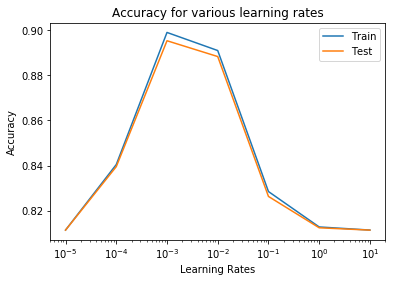

In [54]:
# Plotting accuracy for various learning rates for 100 epochs
plt.plot([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], train_accuracy)
plt.plot([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], test_accuracy)
plt.title('Accuracy for various learning rates')
plt.ylabel('Accuracy')
plt.xlabel('Learning Rates')
plt.xscale('log')
plt.legend(['Train', 'Test'])
plt.show()

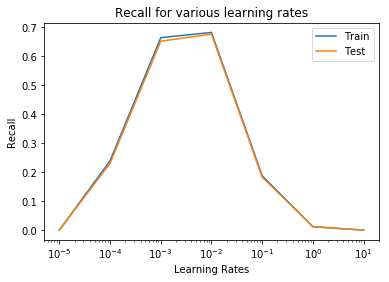

In [55]:
# Plotting recalls for various learning rates for 100 epochs
plt.plot([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], train_recall)
plt.plot([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], test_recall)
plt.title('Recall for various learning rates')
plt.ylabel('Recall')
plt.xlabel('Learning Rates')
plt.xscale('log')
plt.legend(['Train', 'Test'])
plt.show()